# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install pymystem3
!pip install imbalanced-learn -q 
!pip install spacy -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# from pymystem3 import Mystem
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.dummy import DummyClassifier
import re 
import spacy
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


RANDOM_STATE = 42

In [3]:
try:
    data = pd.read_csv(r'C:\Users\Евгений\practicum\df-13\toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.head(2)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0


In [6]:
data['toxic'].unique()

array([0, 1], dtype=int64)

In [7]:
data['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

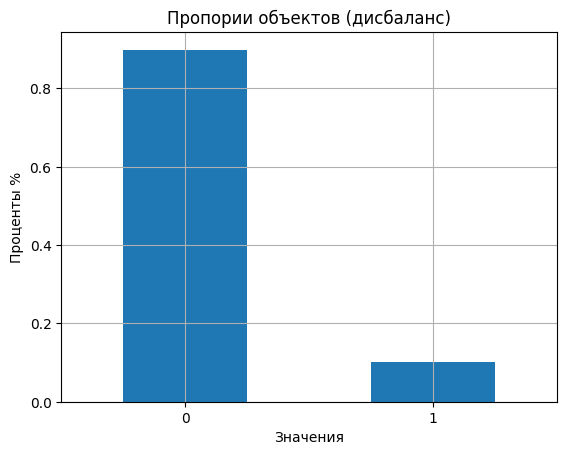

In [8]:
data.toxic.value_counts(normalize=True).plot(kind='bar'
                                             , title="Пропории объектов (дисбаланс)"
                                             , rot=0, xlabel= 'Значения'
                                             , ylabel='Проценты %'
                                             , grid=True)
pass

Дисболанс сумашедший, но решить эту проблему будим после лемматизации.

In [9]:
df = data.copy()

In [10]:
df.drop(columns='Unnamed: 0', inplace=True) # удаляем не нужную колонку

##df['text'] = df['text'].values.astype('U') 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [12]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


__Заключение по предварительному анализу__

Нет пропусков
Относительный большая выборка, что надо будет учитывать при выборе модели. Поскольку медленные могут занять слишком много времени
Неинформативный признак Unnamed: 0, который дублирует индекс
Количество токсичных комментариев составляет 10%
Текст содержит \n символ перехода строки

### Лемматезируем

In [13]:
def clear_text(text):
    text_r = re.sub(r"[^a-zA-Z',.]", " ",text)
    text_s = text_r.split()
    text_j = " ".join(text_s)
    return text_j.lower()

In [14]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [15]:
def lemmatize(text):
    text = clear_text(text)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct]
    return ' '.join(lemmas)

In [16]:
df['text'] = df['text'].apply(lemmatize)
df.head()

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d'aww he match this background colour I be see...,0
2,hey man I be really not try to edit war it be ...,0
3,more I can not make any real suggestion on imp...,0
4,you sir be my hero any chance you remember wha...,0


### Подготовка данных к обучению

In [17]:
X = df.drop(columns = 'toxic', axis=0)
y = df['toxic']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y)

Проверка на адекватность

In [19]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)
dummy_model_probas = dummy_model.predict_proba(X_test)[:,1]

dummy_f1 = f1_score(y_test, dummy_model_preds)
print('F1-score =', round(dummy_f1,2))

F1-score = 0.0


### Семплируем данные

In [20]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
# сэмплируем данные 
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train) 

In [21]:
print(f'Тренировочные данные до сэмплирования:\n{y_train.value_counts()}')
print(f'\nТренировочные данные после сэмплирования:\n{y_train_sampled.value_counts()}')

Тренировочные данные до сэмплирования:
toxic
0    107329
1     12140
Name: count, dtype: int64

Тренировочные данные после сэмплирования:
toxic
0    12140
1    12140
Name: count, dtype: int64


In [22]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
#count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(X_train['text']) # кодируем тренеровочную выборку  

print("Размер матрицы:", tf_idf_train.shape)

Размер матрицы: (119469, 127995)


In [24]:
tf_idf_test = count_tf_idf.transform(X_test['text'])  # кодируем тестовую выборку  

print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (39823, 127995)


## Обучение

### логистическая регрессия

In [25]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 3, n_jobs = -1, param_grid = params, scoring = 'f1', verbose = False)
    grid.fit(X_train['text'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [26]:
mod_lr = training(LogisticRegression(random_state=RANDOM_STATE), {"model__C":[0.1, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.7823545002014742
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [27]:
mod_dtc = training(DecisionTreeClassifier(random_state=RANDOM_STATE), {'model__criterion':['gini','entropy'],'model__max_depth': [None] + [i for i in range(2, 7)]})

Лучший результат: 0.692767428896761
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': None}


In [28]:
print(f'Значение F1 метрики = {round(f1_score(y_test, mod_lr.predict(X_test["text"])), 2)}')

Значение F1 метрики = 0.79


## Выводы

Между классов токсичных и обычных сообщений существует сильный дисбалнс классов  
Устранил дисбаланс, леметезировал данные, и подготовил к обучению.  
Были обучены две модели.  
Получилось обучить модель логистическая регрессия с f1 метрикой 0.79, что проходило под критерием "не меньше 0.75".